In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="geographymodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
geogFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
geogFOSID = geogFOSID.filter(geogFOSID["Domain"]=="Geography").collect()

In [8]:
len(geogFOSID)

50

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(geogFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+---------+
|   FOS_ID|   Domain|
+---------+---------+
| 26271046|Geography|
|100970517|Geography|
+---------+---------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

856842

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [19]:
sample1 = papers_filtered1

In [20]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [21]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|            25|
|           144|
|             8|
|             3|
+--------------+
only showing top 4 rows



In [22]:
sample1_pd = sample1.toPandas()

In [23]:
import numpy as np

In [24]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [25]:
from sklearn import metrics

In [26]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 0.325608455234454)
('Mean Squared Error of EstimatedCount:', 307.12154049404677)
('Root Mean Squared of with EstimatedCount:', 17.52488346591916)


In [27]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [28]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [29]:
from sklearn.model_selection import KFold

In [30]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 0.9768786033692295)
('Mean Squared Error:', 135.68020839976586)
('Root Mean Squared Error:', 11.648184768442071)
('Mean Absolute Error:', 0.20501445991016562)
('Mean Squared Error:', 4.184603419726685)
('Root Mean Squared Error:', 2.045630323329874)
('Mean Absolute Error:', 0.21809275639944187)
('Mean Squared Error:', 12.204195099556275)
('Root Mean Squared Error:', 3.4934503144536455)
('Mean Absolute Error:', 0.24092691823092482)
('Mean Squared Error:', 30.442495273801406)
('Root Mean Squared Error:', 5.517471819031014)
('Mean Absolute Error:', 0.35577488072240104)
('Mean Squared Error:', 17.477181071054282)
('Root Mean Squared Error:', 4.180571859333874)


In [33]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 5.377061816918096)


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
featureslist=sample1_pd.columns

In [36]:
importances = regressor.feature_importances_

In [37]:
import pandas as pd

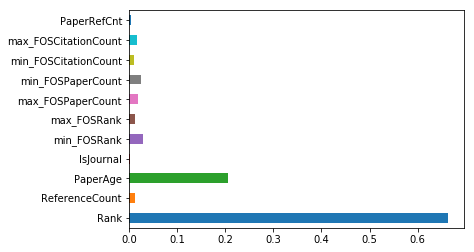

In [38]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [39]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.66263
Feature: 1, Score: 0.01316
Feature: 2, Score: 0.20480
Feature: 3, Score: 0.00254
Feature: 4, Score: 0.02834
Feature: 5, Score: 0.01281
Feature: 6, Score: 0.01971
Feature: 7, Score: 0.02451
Feature: 8, Score: 0.00960
Feature: 9, Score: 0.01757
Feature: 10, Score: 0.00434


## XGBoost Regression model

In [40]:
import xgboost as xgb

In [41]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [42]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([171369, 171370, 171371, ..., 856839, 856840, 856841]), 'TEST:', array([     0,      1,      2, ..., 171366, 171367, 171368]))
('Mean Absolute Error of XGBoost Kfold:', 1.069214739883615)
('Mean Squared Error of XGBoost Kfold:', 154.70359592565612)
('Root Mean Squared Error of XGBoost Kfold:', 12.437990027558959)
('TRAIN:', array([     0,      1,      2, ..., 856839, 856840, 856841]), 'TEST:', array([171369, 171370, 171371, ..., 342735, 342736, 342737]))
('Mean Absolute Error of XGBoost Kfold:', 0.21203553795192623)
('Mean Squared Error of XGBoost Kfold:', 4.794624945457326)
('Root Mean Squared Error of XGBoost Kfold:', 2.1896632036588017)
('TRAIN:', array([     0,      1,      2, ..., 856839, 856840, 856841]), 'TEST:', array([342738, 342739, 342740, ..., 514103, 514104, 514105]))
('Mean Absolute Error of XGBoost Kfold:', 0.2237591238726402)
('Mean Squared Error of XGBoost Kfold:', 14.46336676285411)
('Root Mean Squared Error of XGBoost Kfold:', 3.803073331248572)
('TR

In [43]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 5.960210367730864)


In [44]:
importances = regressor.feature_importances_

In [45]:
import pandas as pd

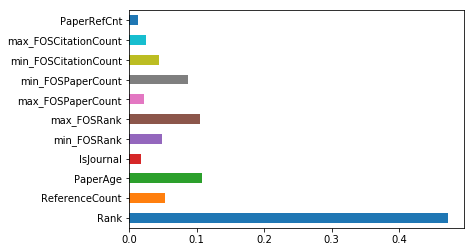

In [46]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [47]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.47184
Feature: 1, Score: 0.05384
Feature: 2, Score: 0.10847
Feature: 3, Score: 0.01826
Feature: 4, Score: 0.04840
Feature: 5, Score: 0.10538
Feature: 6, Score: 0.02249
Feature: 7, Score: 0.08801
Feature: 8, Score: 0.04516
Feature: 9, Score: 0.02519
Feature: 10, Score: 0.01294
